In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Часть 1. Игрушечный набор данных "девушка в баре"
Цель – "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

### Обучающая выборка

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


## Тестовая выборка

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Внешность_отталкивающая,Уровень_красноречия_средний,Уровень_красноречия_высокий,Потраченные_деньги_много,Алкоголь_в_напитке_да,Потраченные_деньги_мало,Внешность_приятная,Алкоголь_в_напитке_нет
0,0,0,1,1,1,0,1,0
1,0,0,0,0,1,1,1,0
2,0,1,0,1,0,0,1,1
3,1,1,0,0,0,1,0,1
4,1,0,0,1,1,0,0,0
5,1,0,1,1,1,0,0,0
6,0,1,0,1,1,0,1,0


In [7]:
df_test

,Внешность_отталкивающая,Уровень_красноречия_средний,Уровень_красноречия_высокий,Потраченные_деньги_много,Алкоголь_в_напитке_да,Потраченные_деньги_мало,Внешность_приятная,Алкоголь_в_напитке_нет
0,0,1,0,1,0,0,1,1
1,0,0,1,0,1,1,1,0
2,1,1,0,1,1,0,0,0


Постройте с помощью sklearn дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.

In [8]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(df_train, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

[Text(111.60000000000001, 190.26, 'X[3] <= 0.5\ngini = 0.49\nsamples = 7\nvalue = [4, 3]'),
 Text(55.800000000000004, 135.9, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 135.9, 'X[0] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(223.20000000000002, 81.53999999999999, 'X[2] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(279.0, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

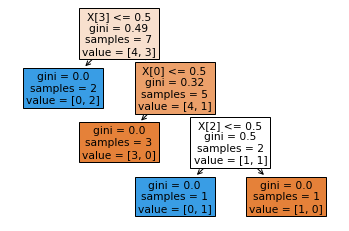

In [9]:
plot_tree(tree, filled=True)

## Часть 2. Функции для расчета энтропии и прироста информации
Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [10]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [11]:
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

Реализуйте функцию для расчета энтропии Шеннона.

In [12]:
from math import log2

def entropy(a_list):
    total = len(a_list)
    blue = a_list.count(1)
    yellow = total - blue
    return -blue/total * log2(blue/total) - yellow/total * log2(yellow/total)

In [13]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878084
0.961236604722876
0.5916727785823275
0.6500224216483541


Прирост информации

In [14]:
def information_gain(root, left, right):
    root_s = enthropy(balls)
    left_s = len(left)/len(root) * entropy(left)
    right_s = len(right)/len(root) * entropy(right)
    return root_s - left_s - right_s    

## Часть 3. Набор данных "Adult"

In [15]:
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capial-loss',
           'hours-per-week', 'native-country', 'salary']
df = pd.read_csv('adult.data.csv', names=colnames, header=None, skipinitialspace=True)

In [16]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capial-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [17]:
df['salary'] = df['salary'].map({'<=50K': 0, '>50K': 1})
X = df.drop('salary', axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Первичный анализ данных.

In [20]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26048.0,38.565802,13.675895,17.0,28.0,37.0,48.0,90.0
fnlwgt,26048.0,189274.069564,105368.387212,12285.0,117363.0,177937.0,236599.5,1455435.0
education-num,26048.0,10.072174,2.572318,1.0,9.0,10.0,12.0,16.0
capital-gain,26048.0,1036.934467,7121.338888,0.0,0.0,0.0,0.0,99999.0
capial-loss,26048.0,86.316109,400.363171,0.0,0.0,0.0,0.0,4356.0
hours-per-week,26048.0,40.363483,12.279460,1.0,40.0,40.0,45.0,99.0


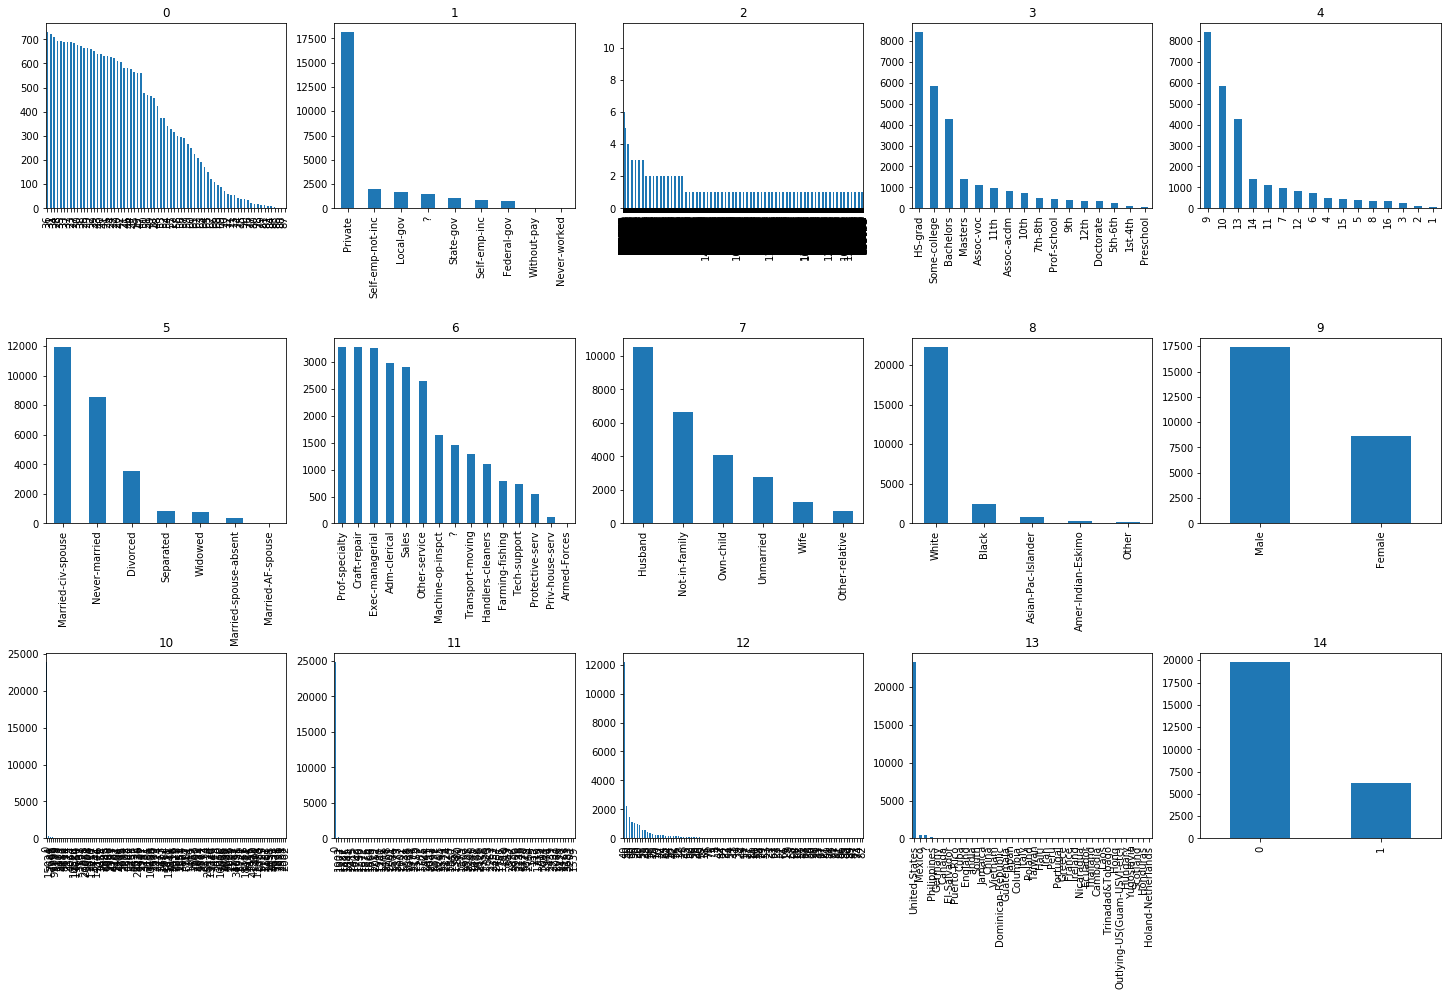

In [25]:
data_train = pd.DataFrame(np.c_[X_train, y_train])

fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [27]:
data_train.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
dtype: object